<a href="https://colab.research.google.com/github/Jiraiagmb/MVP-2---Algoritmo-de-predi-o-de-ataques-em-redes-corporativas/blob/main/NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP 2 - Algoritmo de predição de ataques em redes corporativas**

---



**Guilherme Missaggia Bertolo**

**27/10/2025**



---





## Definição do problema

---



O dataset NSL-KDD contém informações sobre conexões de rede, abrangendo variáveis relacionadas a protocolos, serviços, status de pacotes e características de tráfego. O conjunto é composto por registros classificados como tráfego normal ou ataques de diferentes tipos, incluindo Denial of Service (DoS), Probe, Remote to Local (R2L) e User to Root (U2R).

O objetivo é analisar como essas características influenciam a ocorrência de intrusões e desenvolver modelos capazes de detectar automaticamente atividades maliciosas em redes de computadores. Esse cenário é formalizado como um problema de classificação supervisionada, sendo amplamente utilizado para treinar e avaliar técnicas de Machine Learning aplicadas à segurança da informação.

Nesse trabalho, os diferentes tipos de ataque foram unificados na categoria “ataque”, de forma que o objetivo passou a ser prever se uma conexão é maliciosa ou não, sem distinguir entre os tipos específicos de ataque.

##Premissas
Assume-se que existe uma relação sistemática entre as características das conexões de rede e a ocorrência de atividades maliciosas, de forma que os padrões podem ser aprendidos por um modelo de classificação supervisionada. Considera-se também que os dados do dataset NSL-KDD são suficientemente representativos do comportamento de tráfego de rede, abrangendo tanto interações legítimas quanto diferentes tipos de ataques, sem vieses que comprometam a análise. Além disso, presume-se que cada registro representa uma conexão independente, ou seja, o comportamento de uma sessão de rede não influencia diretamente o de outra. Outro ponto assumido é que as variáveis disponíveis no conjunto de dados são relevantes e capazes de explicar uma parcela significativa da variabilidade entre conexões normais e maliciosas, e que essas relações permanecem consistentes, permitindo a generalização dos modelos desenvolvidos para novos cenários de detecção de intrusão.

##Dataset


*   Fonte: Kaggle
*   Link: https://www.kaggle.com/datasets/hassan06/nslkdd/data
*   Atributos: O dataset NSL-KDD possui 41 variáveis independentes que descrevem diferentes características das conexões de rede, incluindo informações sobre protocolos, serviços, status de pacotes, conteúdo da comunicação e estatísticas de tráfego em janelas temporais. A variável dependente é o rótulo de classe, que indica se a conexão é normal ou corresponde a um ataque, categorizado em uma das quatro classes principais: DoS, Probe, R2L ou U2R.

## **1. Importando bibliotecas**

---



In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from google.colab import drive
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (10,6)


### **2. Lendo o dataset**

---

O dataset é lido no Google Drive. No caminho Meu Drive/NSL KDD/.


In [57]:
# ID do arquivo no Google Drive
file_id = "1nQ2Y1ByrFTje4P3uxdHNNKcC8oNXaWmu"

# Link direto de download
url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(url, header=None)

# Número de linhas (registros)
n_row1 = df.shape[0]
print('Número de registros:', n_row1)

# Exibindo o DataFrame
df

Número de registros: 125973


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.060,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.960,0.010,0.010,0.000,0.000,0.000,0.000,0.000,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.120,0.060,0.000,0.000,0.720,0.000,0.010,0.000,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.030,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20


## **3. Preparação dos dados**

---

O dataset NSL-KDD é fornecido originalmente sem os nomes das colunas, sendo necessário atribuí-los manualmente antes de poder manipular e analisar os dados de forma eficaz.

Na etapa inicial de preparação dos dados, a variável alvo foi padronizada para “normal”, indicando uma conexão legítima, e “attack”, indicando a ocorrência de atividade maliciosa. Para isso, os quatro tipos distintos de ataque presentes no dataset foram unificados na categoria “attack”, garantindo consistência na análise.

Para a aplicação dos algoritmos de aprendizado de máquina, foi necessário realizar a etapa de pré-processamento, garantindo que todas as variáveis estivessem em formato numérico e adequadas para o treinamento dos modelos.
As variáveis categóricas foram convertidas para o números inteiros, assegurando uniformidade no conjunto de dados.

Por fim, todas as colunas do DataFrame, exceto outcome, foram atribuídas à variável X, representando os atributos que servirão como entrada para o modelo. A coluna outcome foi separada na variável Y, correspondendo à variável que se deseja prever.

Obs: Foi analisado que o dataset não possui atributos vazios, nem linhas duplicadas.

In [58]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])
df.columns = columns
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.170,0.030,0.170,0.000,0.000,0.000,0.050,0.000,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.000,0.600,0.880,0.000,0.000,0.000,0.000,0.000,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.000,0.000,0.030,0.040,0.030,0.010,0.000,0.010,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.100,0.060,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.960,0.010,0.010,0.000,0.000,0.000,0.000,0.000,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.120,0.060,0.000,0.000,0.720,0.000,0.010,0.000,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.030,0.050,0.000,0.000,1.000,1.000,0.000,0.000,neptune,20


In [59]:
df.loc[df['outcome'] == "normal", "outcome"] = 'normal'
df.loc[df['outcome'] != 'normal', "outcome"] = 'attack'
df.outcome

,outcome
0,normal
1,normal
2,attack
3,normal
4,normal
...,...
125968,attack
125969,normal
125970,normal
125971,attack


In [60]:
df['outcome'].unique()

array(['normal', 'attack'], dtype=object)

In [61]:
cat_features = df.select_dtypes(include='object').columns
cat_features

Index(['protocol_type', 'service', 'flag', 'outcome'], dtype='object')

In [62]:
le=preprocessing.LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'outcome']
for x in clm:
    df[x]=le.fit_transform(df[x])

df[clm].head()

,protocol_type,service,flag,outcome
0,1,20,9,1
1,2,44,9,1
2,1,49,5,0
3,1,24,9,1
4,1,24,9,1


In [63]:
X = df.drop(["outcome"], axis=1)
Y = df["outcome"]

## **4. Selecionando melhores atributos**

---

Para analisar o impacto de cada variável na classificação, é possível calcular a importância de cada atributo em relação ao alvo, utilizando técnicas como informação mútua, que mede quanto cada feature ajuda a prever se a conexão é normal ou maliciosa. Um gráfico de barras ordenando as variáveis do mais para o menos relevante permite visualizar rapidamente quais atributos contribuem mais para a detecção de ataques.

Além disso, métodos de seleção de atributos, como ANOVA F (f_classif), podem ser usados para escolher as variáveis mais relevantes. Por exemplo, selecionando apenas as 17 variáveis mais significativas, reduz-se a dimensionalidade do dataset, simplificando o modelo e focando nos atributos que realmente impactam a classificação.

A escolha dos atributos mais importantes é fundamental, pois melhora o desempenho do modelo, reduz o tempo de treino, diminui o risco de overfitting e ajuda a interpretar quais características da rede são críticas para identificar ataques.

In [64]:
names=list(X.columns)
# Seleção de atributos
n_selected=17 # Digitar aqui o número de atributos a serem selecionados
test = SelectKBest(score_func=f_classif, k=n_selected)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
features = fit.transform(X)
# list(data) or
performance_list = pd.DataFrame(
    {'Attribute': names,
     'Value': fit.scores_
    })
performance_list=performance_list.sort_values(by=['Value'], ascending=False)
names_selected=performance_list.values[0:n_selected,0]

XX = pd.DataFrame (X, columns = names_selected)
X=XX
X

,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,logged_in,dst_host_srv_serror_rate,dst_host_serror_rate,serror_rate,srv_serror_rate,flag,count,level,dst_host_count,protocol_type,service,srv_rerror_rate,dst_host_srv_rerror_rate,rerror_rate
0,1.000,25,0.170,0,0.000,0.000,0.000,0.000,9,2,20,150,1,20,0.000,0.000,0.000
1,0.080,1,0.000,0,0.000,0.000,0.000,0.000,9,13,15,255,2,44,0.000,0.000,0.000
2,0.050,26,0.100,0,1.000,1.000,1.000,1.000,5,123,19,255,1,49,0.000,0.000,0.000
3,1.000,255,1.000,1,0.010,0.030,0.200,0.200,9,5,21,30,1,24,0.000,0.010,0.000
4,1.000,255,1.000,1,0.000,0.000,0.000,0.000,9,30,21,255,1,24,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.140,25,0.100,0,1.000,1.000,1.000,1.000,5,184,20,255,1,49,0.000,0.000,0.000
125969,1.000,244,0.960,0,0.000,0.000,0.000,0.000,9,2,21,255,2,49,0.000,0.000,0.000
125970,1.000,30,0.120,1,0.000,0.720,0.000,0.000,9,1,18,255,1,54,0.000,0.000,0.000
125971,0.060,8,0.030,0,1.000,1.000,1.000,1.000,5,144,20,255,1,30,0.000,0.000,0.000


## **5. Dividindo dataset em treino e teste**
---

O código separa os dados em treino (70%) e teste (30%) para que o modelo possa ser treinado em uma parte dos dados e avaliado em dados que ele ainda não conhece. Além disso, para melhorar o desempenho do modelo, foi feita a padronização dos dados. Dados padronizados são importantes para uso em modelos sensíveis à escala. O código cria e treina os modelos XGBoostClassifier e LogisticRegression usando os dados de treino.

Matrizes de confusão e relatórios de classificação são calculados e gerados  para os conjuntos de treino e teste.

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=43)

train_index = X_train.columns
train_index
Y

,outcome
0,1
1,1
2,0
3,1
4,1
...,...
125968,0
125969,1
125970,1
125971,0


In [66]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **5. Avaliação dos resultados**
---

Os códigos implementam e avaliam dois modelos de classificação supervisionada: Regressão Logística e XGBoost. Ambos os modelos são treinados com o conjunto de dados de treinamento e, em seguida, utilizados para gerar previsões sobre os dados de teste. A avaliação de desempenho é realizada por meio da matriz de confusão e do relatório de classificação, que apresentam métricas como acurácia, precisão, recall e F1-score. Além disso, para problemas binários, são geradas as curvas ROC e Precision-Recall, que permitem uma análise mais detalhada da capacidade discriminativa e do equilíbrio entre precisão e sensibilidade dos classificadores.

Resultados sobre o algoritmo de Regressão Logística: o conjunto de métricas e visualizações demonstra um desempenho excelente do modelo de classificação, indicando que ele está maduro para implantação em um cenário prático. A Área Sob a Curva (AUC) de 0.99 na Curva ROC atesta uma capacidade discriminatória quase perfeita, significando que o modelo pode distinguir as classes com altíssima confiabilidade. Este desempenho é corroborado pela acurácia de 96% e pelo F1-score consistentemente alto (0.96-0.97) em ambas as classes, mostrando que o modelo é preciso e equilibrado. A Matriz de Confusão confirma essa robustez ao revelar um número muito baixo de Falsos Positivos e Falsos Negativos (627 e 706, respectivamente) em relação ao total de 37.792 casos testados, garantindo que, na prática, o modelo fará um número mínimo.

Os resultados do modelo XGBoost mostram um desempenho praticamente perfeito no conjunto de teste: a matriz de confusão indica apenas 16 falsos positivos e 33 falsos negativos, com a grande maioria das previsões corretas para ambas as classes. O relatório de classificação confirma isso, apresentando precisão, recall e f1-score iguais a 1.00 para ambas as classes, e uma acurácia total de 100%. A curva ROC evidencia uma separação perfeita entre classes, com área sob a curva igual a 1.00, enquanto a curva Precision-Recall também demonstra máxima precisão e recall, confirmando a capacidade do modelo de identificar corretamente todas as instâncias sem erros significativos. Em resumo, o XGBoost atingiu desempenho perfeito nos dados de teste apresentados.

Esses resultados sugerem quase excelência, mas cria uma forte suspeita de overfitting, exigindo validação com dados novos e externos para confirmar a robustez do modelo na prática.

In [67]:
def avaliar_modelo(modelo, X_train, Y_train, X_test, Y_test, nome_modelo="Modelo"):
    # Predições
    Y_train_pred = modelo.predict(X_train)
    Y_test_pred = modelo.predict(X_test)

    # Matriz de Confusão
    cm = confusion_matrix(Y_test, Y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo} (Teste)')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    # Relatório de Classificação
    print(f"Relatório de Classificação ({nome_modelo} - Teste):")
    print(classification_report(Y_test, Y_test_pred))

    # ROC e AUC (para classificação binária)
    if len(set(Y_test)) == 2:
        Y_test_prob = modelo.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(Y_test, Y_test_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (área = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}')
        plt.legend(loc='lower right')
        plt.show()

        precision, recall, _ = precision_recall_curve(Y_test, Y_test_prob)
        plt.figure()
        plt.plot(recall, precision, color='purple')
        plt.xlabel('Recall')
        plt.ylabel('Precisão')
        plt.title(f'Curva Precision-Recall - {nome_modelo}')
        plt.show()

In [68]:
logistic_model = LogisticRegression(random_state=42).fit(X_train, Y_train)
XGBoost_model = XGBClassifier(random_state=42).fit(X_train, Y_train)

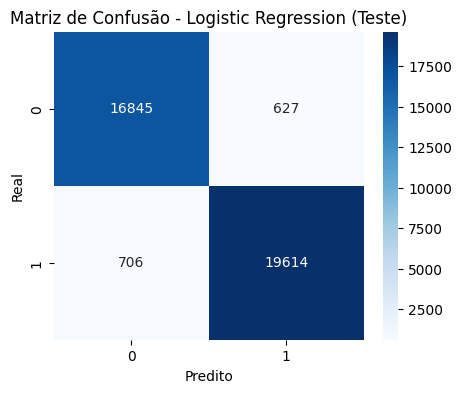

Relatório de Classificação (Logistic Regression - Teste):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17472
           1       0.97      0.97      0.97     20320

    accuracy                           0.96     37792
   macro avg       0.96      0.96      0.96     37792
weighted avg       0.96      0.96      0.96     37792



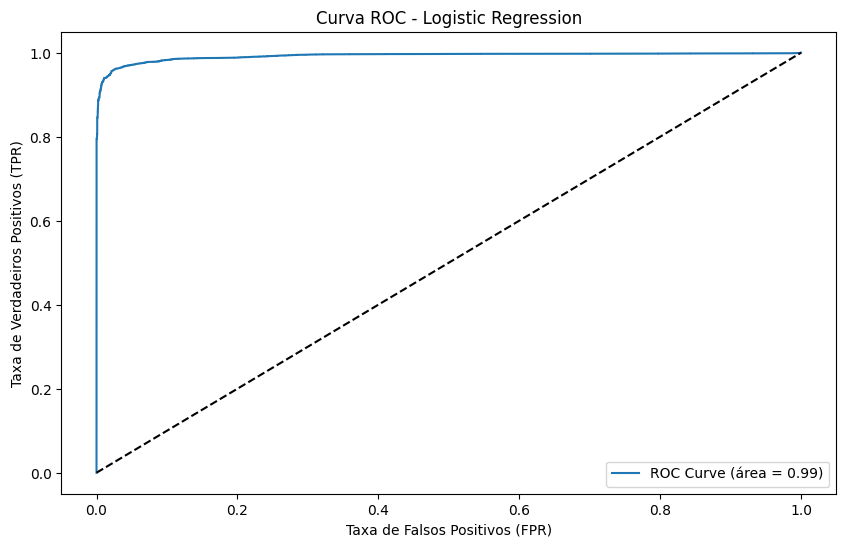

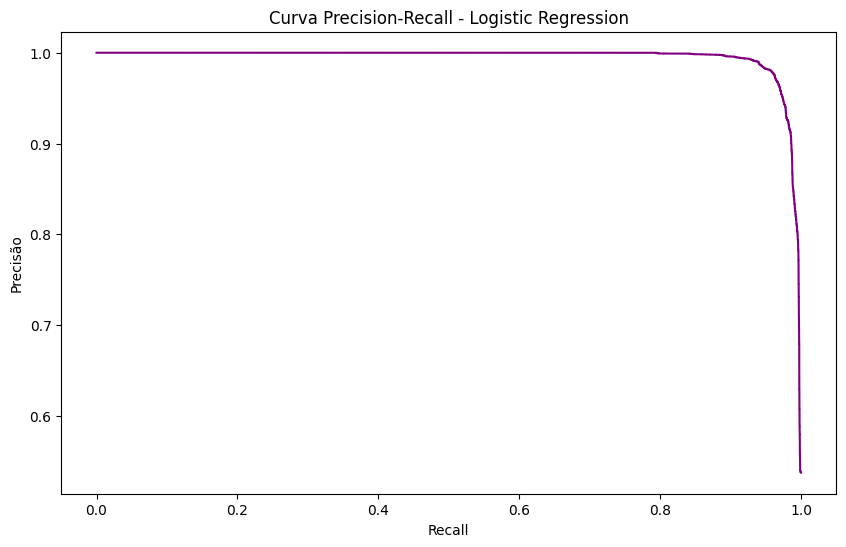

In [69]:
avaliar_modelo(logistic_model, X_train, Y_train, X_test, Y_test, nome_modelo="Logistic Regression")


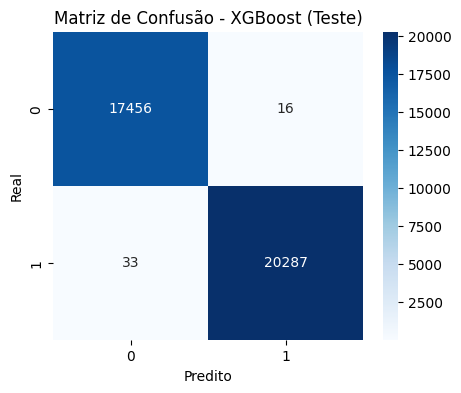

Relatório de Classificação (XGBoost - Teste):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17472
           1       1.00      1.00      1.00     20320

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



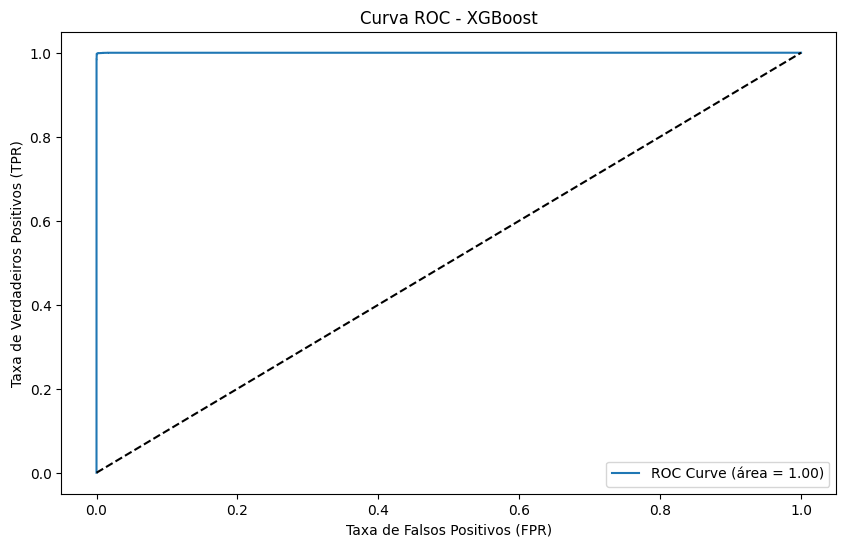

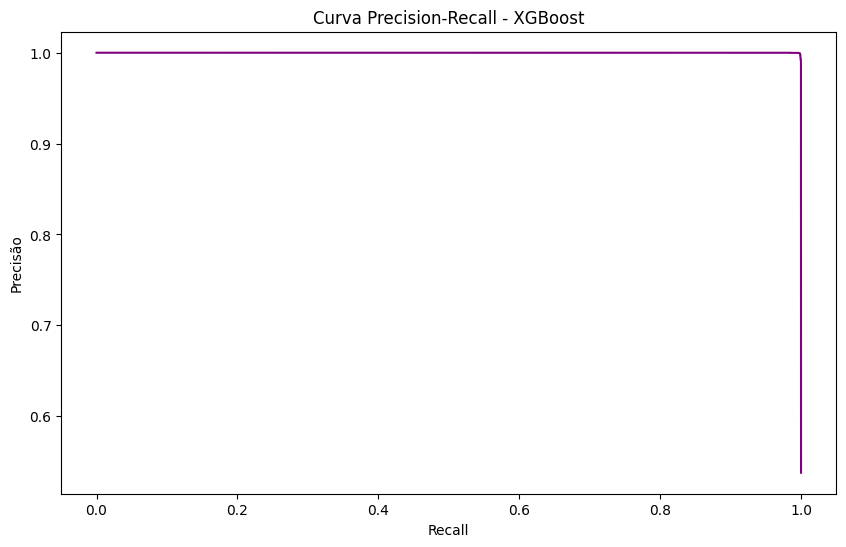

In [70]:
avaliar_modelo(XGBoost_model, X_train, Y_train, X_test, Y_test, nome_modelo="XGBoost")

## **6 Otimizando os modelos**

Os algoritmo testam várias combinações de parâmetros do modelo (hiperparâmetros) e, para cada combinação, eles avaliam seu desempenho de forma confiável usando validação cruzada, escolhendo no final a configuração que obtém os melhores resultados.

Para a construção dos modelos de classificação, foram utilizados dois algoritmos: Regressão Logística e XGBoost. Ambos os modelos passaram por uma validação cruzada estratificada de cinco folds, permitindo avaliar de forma robusta métricas de desempenho como acurácia, precisão, recall e F1-score em cada partição do conjunto de dados. Após a validação, cada modelo foi treinado com o conjunto completo de dados, de modo a gerar o modelo final, que foi posteriormente salvo para uso em predições futuras. A Regressão Logística, por se tratar de um modelo linear, apresenta interpretação direta dos coeficientes, enquanto o XGBoost, baseado em árvores de decisão em gradiente, explora relações não lineares e interações complexas entre as variáveis, permitindo comparações entre abordagens lineares e não lineares no contexto do problema estudado.

Os modelos otimizados mostraram valores muito próximos aos encontrados no passo anterior. O algoritmo de Regressão Linear encontrou um score geral de 0.9677232422820763. Já o algoritmo XGBoost encontrou um score geral de 0.9996507188048233.

In [71]:
#Definir o modelo

Logistic_model = LogisticRegression(
    random_state=42,
    max_iter=5000,
    class_weight='balanced',  # opcional — ajuda se as classes forem desbalanceadas
    solver='lbfgs'            # pode trocar para 'liblinear' ou 'saga' se quiser
)


#Validação Cruzada Manual (Stratified K-Fold)

accuracies = []
precisions = []
recalls = []
f1s = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, Y), start=1):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    # Treinar modelo
    Logistic_model.fit(X_train_fold, Y_train_fold)

    # Prever
    Y_pred = Logistic_model.predict(X_test_fold)

    # Calcular métricas
    acc = accuracy_score(Y_test_fold, Y_pred)
    prec = precision_score(Y_test_fold, Y_pred)
    rec = recall_score(Y_test_fold, Y_pred)
    f1 = f1_score(Y_test_fold, Y_pred)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Fold {fold} — Acurácia: {acc:.6f}, Precisão: {prec:.6f}, Recall: {rec:.6f}, F1: {f1:.6f}")

# Resultados médios da validação cruzada
print("\n--- MÉDIAS DA VALIDAÇÃO CRUZADA (5-Fold) ---")
print("Acurácia média:", np.mean(accuracies))
print("Precision média:", np.mean(precisions))
print("Recall médio:", np.mean(recalls))
print("F1-score médio:", np.mean(f1s))


#Treinar modelo final com todos os dados

print("\nTreinando modelo final com todos os dados...")
Logistic_model.fit(X, Y)


# Salvar o modelo para a variável `logistic_model_bytes`
logistic_model_bytes = pickle.dumps(Logistic_model)
print("Modelo Logistic Regression salvo em variável com sucesso!")


#Score geral do modelo treinado em todo o dataset

score = Logistic_model.score(X, Y)
print("\nScore geral no conjunto completo:", score)


Fold 1 — Acurácia: 0.967692, Precisão: 0.973155, Recall: 0.966219, F1: 0.969674
Fold 2 — Acurácia: 0.968287, Precisão: 0.976101, Recall: 0.964288, F1: 0.970159
Fold 3 — Acurácia: 0.967057, Precisão: 0.975115, Recall: 0.962952, F1: 0.968995
Fold 4 — Acurácia: 0.967254, Precisão: 0.974124, Recall: 0.964360, F1: 0.969218
Fold 5 — Acurácia: 0.968088, Precisão: 0.975019, Recall: 0.965028, F1: 0.969998

--- MÉDIAS DA VALIDAÇÃO CRUZADA (5-Fold) ---
Acurácia média: 0.9676756129529511
Precision média: 0.9747027264348718
Recall médio: 0.964569446702493
F1-score médio: 0.969608718478411

Treinando modelo final com todos os dados...
Modelo Logistic Regression salvo em variável com sucesso!

Score geral no conjunto completo: 0.9677232422820763


In [72]:
#Validação Cruzada Manual (Stratified K-Fold)

accuracies = []
precisions = []
recalls = []
f1s = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, Y), start=1):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    # Treinar modelo (pode ser Logistic_model ou XGBoost_model)
    XGBoost_model.fit(X_train_fold, Y_train_fold)

    # Prever
    Y_pred = XGBoost_model.predict(X_test_fold)

    # Calcular métricas
    acc = accuracy_score(Y_test_fold, Y_pred)
    prec = precision_score(Y_test_fold, Y_pred)
    rec = recall_score(Y_test_fold, Y_pred)
    f1 = f1_score(Y_test_fold, Y_pred)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Fold {fold} — Acurácia: {acc:.6f}, Precisão: {prec:.6f}, Recall: {rec:.6f}, F1: {f1:.6f}")

# Resultados médios da validação cruzada
print("\n--- MÉDIAS DA VALIDAÇÃO CRUZADA (5-Fold) ---")
print("Acurácia média:", np.mean(accuracies))
print("Precision média:", np.mean(precisions))
print("Recall médio:", np.mean(recalls))
print("F1-score médio:", np.mean(f1s))


#Treinar modelo final com todos os dados
print("\nTreinando modelo final com todos os dados...")
XGBoost_model.fit(X, Y)

# Salvar o modelo diretamente em uma variável
model_bytes = pickle.dumps(XGBoost_model)
print("Modelo salvo em variável com sucesso!")

#Score geral do modelo treinado em todo o dataset
score = XGBoost_model.score(X, Y)
print("\nScore geral no conjunto completo:", score)

Fold 1 — Acurácia: 0.998690, Precisão: 0.999331, Recall: 0.998218, F1: 0.998774
Fold 2 — Acurácia: 0.998849, Precisão: 0.999331, Recall: 0.998515, F1: 0.998923
Fold 3 — Acurácia: 0.998174, Precisão: 0.998811, Recall: 0.997773, F1: 0.998291
Fold 4 — Acurácia: 0.998730, Precisão: 0.998886, Recall: 0.998738, F1: 0.998812
Fold 5 — Acurácia: 0.998849, Precisão: 0.999257, Recall: 0.998589, F1: 0.998923

--- MÉDIAS DA VALIDAÇÃO CRUZADA (5-Fold) ---
Acurácia média: 0.9986584447611717
Precision média: 0.9991232487902852
Recall médio: 0.9983665799539286
F1-score médio: 0.9987447416215407

Treinando modelo final com todos os dados...
Modelo salvo em variável com sucesso!

Score geral no conjunto completo: 0.9996507188048233


## **7 Validação**

A etapa de validação em Machine Learning é essencial para verificar a capacidade de generalização do modelo, assegurando que ele apresente bom desempenho não apenas sobre os dados de treinamento, mas também diante de novas amostras. Esse processo tem como objetivo principal evitar o overfitting, avaliar o desempenho real do modelo e apoiar o ajuste de hiperparâmetros e a seleção de features mais relevantes, resultando em modelos mais robustos, confiáveis e representativos do problema estudado.

Para a validação do modelo proposto, foi utilizado o conjunto de dados KDDTest+.txt, o qual contém instâncias distintas das utilizadas no treinamento. O modelo previamente salvo foi carregado e aplicado sobre esse novo conjunto, permitindo uma análise comparativa de desempenho entre diferentes algoritmos.

Os resultados obtidos demonstraram que o modelo baseado no algoritmo XGBoost alcançou uma acurácia de 91,39%, enquanto o modelo de Regressão Logística apresentou acurácia de 87,71%. Esses valores indicam que o XGBoost obteve melhor capacidade de generalização e maior precisão na detecção de padrões, evidenciando seu potencial para aplicações em detecção de intrusões e análise de tráfego de rede.

In [73]:
# Lendo o arquivo TXT
# Link direto de download
file_id = "1o-PPGtn1iFk5PpPUg1NNm3s1oG7P-W3s"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df2 = pd.read_csv(url, header=None, names=columns)

# Número de linhas (registros)
n_row1 = df2.shape[0]
print('Número de registros:', n_row1)

# Ler o modelo a partir da variável
loaded_model = pickle.loads(model_bytes)


#Realizando os mesmos ajustes no Dataset feitos previamente nos dados de treino
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])
df2.columns = columns

df2.loc[df2['outcome'] == "normal", "outcome"] = 'normal'
df2.loc[df2['outcome'] != 'normal', "outcome"] = 'attack'

le2=preprocessing.LabelEncoder()
clm2=['protocol_type', 'service', 'flag', 'outcome']
for x in clm2:
    df2[x]=le2.fit_transform(df2[x])


X_our_data = df2.drop([
    'outcome', 'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
    'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'srv_count', 'rerror_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate'
], axis=1)
Y_our_data = df2.outcome


XXX = pd.DataFrame (X_our_data, columns = names_selected)
X_our_data=XXX

#Realizando a predição
Y2_pred=loaded_model.predict(X_our_data)
df3 = pd.DataFrame(Y2_pred, columns = ['outcome'])

df3.to_excel((proj_path + "02_Predicoes_Dados_Proprios.xlsx"), sheet_name='Predicoes')


accuracy = accuracy_score(Y_our_data, Y2_pred)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Número de registros: 22544
Acurácia: 91.39%


In [74]:
# Lendo o arquivo TXT (sem planilha)
file_id = "1o-PPGtn1iFk5PpPUg1NNm3s1oG7P-W3s"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df4 = pd.read_csv(url, header=None, names=columns)

# Número de linhas (registros)
n_row2 = df4.shape[0]
print('Número de registros:', n_row2)

#Ler o modelo a partir da variável
loaded_model = pickle.loads(logistic_model_bytes)


#Realizando os mesmos ajustes no Dataset feitos previamente nos dados de treino
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])
df4.columns = columns

df4.loc[df4['outcome'] == "normal", "outcome"] = 'normal'
df4.loc[df4['outcome'] != 'normal', "outcome"] = 'attack'

le3=preprocessing.LabelEncoder()
clm3=['protocol_type', 'service', 'flag', 'outcome']
for x in clm3:
    df4[x]=le3.fit_transform(df4[x])


X_our_data2 = df4.drop(["outcome"], axis=1)
Y_our_data2 = df4.outcome


XXXX = pd.DataFrame (X_our_data2, columns = names_selected)
X_our_data2=XXXX

#Realizando a predição
Y3_pred=loaded_model.predict(X_our_data2)
df5 = pd.DataFrame(Y3_pred, columns = ['outcome'])

df5.to_excel((proj_path + "02_Predicoes_Dados_Proprios.xlsx"), sheet_name='Predicoes')


accuracy = accuracy_score(Y_our_data2, Y3_pred)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Número de registros: 22544
Acurácia: 87.71%


## **9. Conclusão**

---



Os experimentos realizados demonstraram a eficácia dos modelos de Machine Learning aplicados à detecção de intrusões em redes de computadores, utilizando o conjunto de dados NSL-KDD como base. Foram implementados e comparados dois algoritmos supervisionados — Regressão Logística e XGBoost — com o objetivo de identificar padrões anômalos capazes de distinguir tráfego normal de atividades maliciosas.

Durante a fase de treinamento, os modelos apresentaram desempenho satisfatório, com scores gerais de 0,9677 para a Regressão Logística e 0,9996 para o XGBoost, evidenciando a capacidade de ambos em aprender as características presentes no conjunto de dados. Entretanto, ao aplicar os modelos a um novo conjunto de validação (KDDTest+.txt), observou-se uma diferença significativa na capacidade de generalização: o modelo baseado em XGBoost atingiu uma acurácia de 91,39%, enquanto o modelo de Regressão Logística obteve 87,71%.

Esses resultados indicam que o XGBoost apresentou melhor desempenho tanto em termos de aprendizado quanto de generalização, mostrando-se mais eficiente para a tarefa de detecção de intrusões. Sua capacidade de lidar com relações não lineares e interações complexas entre as variáveis contribuiu para essa superioridade.

De modo geral, conclui-se que o uso de técnicas avançadas de Machine Learning, como o XGBoost, pode aprimorar significativamente a detecção de atividades maliciosas em ambientes de rede, contribuindo para o desenvolvimento de sistemas de segurança mais precisos e adaptáveis.

Como proposta para trabalhos futuros, pretende-se ampliar este estudo explorando outras abordagens de aprendizado de máquina e técnicas de aprendizado profundo que podem capturar padrões temporais e comportamentais mais complexos presentes no tráfego de rede. Além disso, sugere-se a aplicação de métodos de seleção e redução de atributos, a fim de otimizar o desempenho computacional e aprimorar a interpretabilidade dos modelos.

Tabmbém sugere-se explorar a classificação detalhada dos diferentes tipos de ataques (DoS, Probe, U2R, R2L), utilizando algoritmos avançados de Machine Learning e aprendizado profundo.